# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [3]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [4]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [5]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [7]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [8]:
# https://stackoverflow.com/a/47091490/4084039
import re
from bs4 import BeautifulSoup
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [9]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [10]:
SORT_DATA = final.sort_values("Time")

In [11]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(SORT_DATA['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364171/364171 [04:57<00:00, 1226.14it/s]


In [12]:
SORT_DATA['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [13]:
TEXT=np.array(SORT_DATA['Text'][0:50000])

In [14]:
TEXT[0]

"this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college"

In [15]:
DATA = np.array(preprocessed_reviews[0:50000])
LABEL  = np.array(SORT_DATA['Score'][0:50000])

In [16]:
#from sklearn.model_selection import train_test_split
#X_train_temp, X_TEST, Y_train_temp, Y_TEST = train_test_split(DATA, LABEL, test_size=0.33,stratify=LABEL)
#X_TRAIN, X_CV, Y_TRAIN, Y_CV = train_test_split(X_train_temp, Y_train_temp, test_size=0.33,stratify=Y_train_temp)

# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

# BOW

In [17]:
#.....CONVERT it into BOW VECTORS....
from sklearn.feature_extraction.text import CountVectorizer
OBJ_BOW = CountVectorizer()
OBJ_BOW.fit(DATA)




X_TRAIN_BOW =OBJ_BOW.transform(DATA)
#X_CV_BOW = OBJ_BOW.transform(X_CV)
#X_TEST_BOW = OBJ_BOW.transform(X_TEST)




print("After vectorizations")
print(X_TRAIN_BOW.shape)
#print(X_CV_BOW.shape,Y_CV.shape)
#print(X_TEST_BOW.shape, Y_TEST.shape)
print("="*100)

After vectorizations
(50000, 42333)


# TFIDF

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
VECTORIZER_TF_IDF = TfidfVectorizer(ngram_range=(1,2), min_df=10)
VECTORIZER_TF_IDF.fit(DATA)


X_TRAIN_TFIDF = VECTORIZER_TF_IDF.transform(DATA)
#X_CV_TFIDF = VECTORIZER_TF_IDF.transform(X_CV)
#X_TEST_TFIDF = VECTORIZER_TF_IDF.transform(X_TEST)



print("After vectorizations")
print(X_TRAIN_TFIDF.shape)
#print(X_CV_TFIDF.shape,Y_CV.shape)
#print(X_TEST_TFIDF.shape, Y_TEST.shape)
print("="*100)



After vectorizations
(50000, 27881)


# AVG W2V

In [19]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in DATA:
    list_of_sentance.append(sentance.split())

 # min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))


number of words that occured minimum 5 times  13694


In [20]:
def AVGW2V(X_test):
   
    i=0
    list_of_sentance=[]
    for sentance in X_test:
        list_of_sentance.append(sentance.split())
    test_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        test_vectors.append(sent_vec)
    return test_vectors

In [21]:
AV_TRAIN_BOW = AVGW2V(DATA)
#AV_CV_BOW = AVGW2V(X_CV)
#AV_TEST_BOW = AVGW2V(X_TEST)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [04:57<00:00, 168.05it/s]


# TFIDF W2V

In [22]:

model = TfidfVectorizer()
model.fit(DATA)

dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf



In [23]:



def TFIDFW2V(test):
    '''
    Returns tfidf word2vec
    '''
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    i=0
    list_of_sentance=[]
    for sentance in test:
        list_of_sentance.append(sentance.split())
        
    for sent in tqdm(list_of_sentance): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
     
    return tfidf_sent_vectors
      

In [24]:
AV_TRAIN_TFIDF = TFIDFW2V(DATA)
#AV_CV_TFIDF = TFIDFW2V(X_CV)
#AV_TEST_TFIDF = TFIDFW2V(X_TEST)  

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [1:13:14<00:00, 11.38it/s]


## [5.1] K-Means Clustering

In [24]:
from sklearn.cluster import KMeans

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

In [25]:
# Please write all the code with proper documentation
k_values = [2,3,4,5,6,7,8,9,10]
INERTIA = []
for k in tqdm(k_values):
    kmeans = KMeans(n_clusters=k).fit(X_TRAIN_BOW)
    INERTIA.append(kmeans.inertia_)
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [4:38:35<00:00, 2115.66s/it]


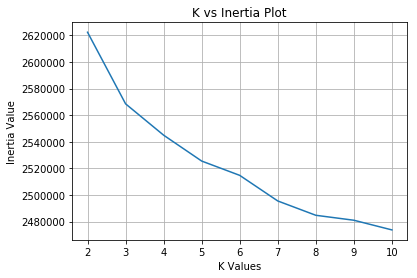

In [33]:
import matplotlib.pyplot as plt
plt.plot(k_values,INERTIA)
plt.grid(True)
plt.title("K vs Inertia Plot")
plt.xlabel("K Values")
plt.ylabel("Inertia Value")
plt.show()

In [38]:
print("OPTIMAL_K = 5")
FINAL_kmeans = KMeans(n_clusters=5).fit(X_TRAIN_BOW)

OPTIMAL_K = 5


In [46]:
from wordcloud import WordCloud
# https://www.geeksforgeeks.org/generating-word-cloud-python/
def cloud(cluster):
    wordcloud = WordCloud(collocations=False, background_color ='white', 
                    min_font_size = 10).generate(str(list(cluster)))
    plt.figure(figsize = (6,6), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title("Cluster",size= 30,)
    plt.show() 


### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

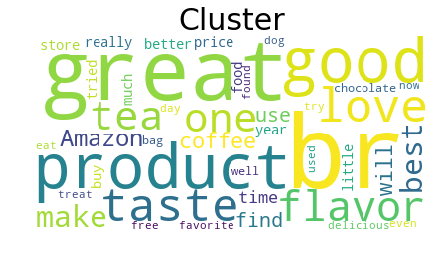

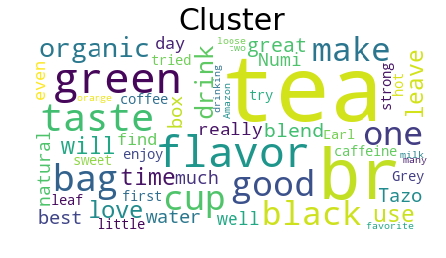

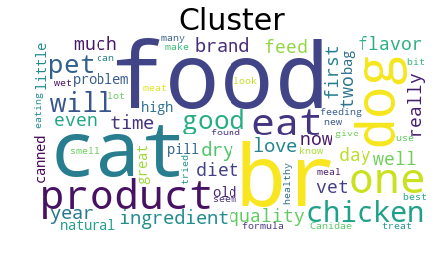

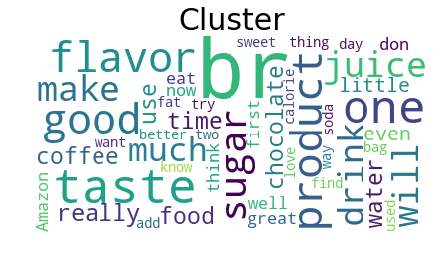

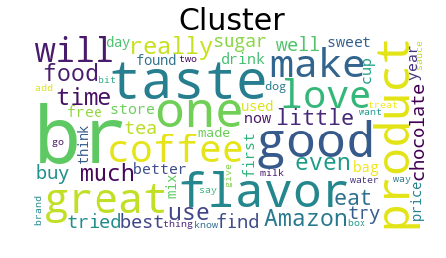

In [61]:
CLUSTER_1=[]
CLUSTER_2=[]
CLUSTER_3=[]
CLUSTER_4=[]
CLUSTER_5=[]
for i in range(FINAL_kmeans.labels_.shape[0]):
    if FINAL_kmeans.labels_[i] == 0:
        CLUSTER_1.append(TEXT[i])
    if FINAL_kmeans.labels_[i] == 1:
        CLUSTER_2.append(TEXT[i])
    if FINAL_kmeans.labels_[i] == 2:
        CLUSTER_3.append(TEXT[i])
    if FINAL_kmeans.labels_[i] == 3:
        CLUSTER_4.append(TEXT[i])
    if FINAL_kmeans.labels_[i] == 4:
        CLUSTER_5.append(TEXT[i])
cloud(CLUSTER_1)
cloud(CLUSTER_2)
cloud(CLUSTER_3)
cloud(CLUSTER_4)
cloud(CLUSTER_5)

# CLUSTER 1: Great,Good,Better,Delecious (words in this cluster are telling about flavour,or taste of product)
# CLUSTER 2:Organic,green,cup,tea,black (words in this cluster is  about tea or coffee)
# CLUSTER 3:Cat,Dog,Chicken,eat,pet (about Animals)
# CLUSTER 4:Sugar,drink,water,juice,taste,flavour,sweet (it is contain words realted to liquid product)
# CLUSTER 5:Product,Love,Good,Great,Much,best(it is contain words realted to customer positive opinion about product) 

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

In [27]:
# Please write all the code with proper documentation
k_values = [2,3,4,5,6,7,8,9,10]
INERTIA_2 = []
for k in tqdm(k_values):
    kmeans = KMeans(n_clusters=k).fit(X_TRAIN_TFIDF)
    INERTIA_2.append(kmeans.inertia_)
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [8:11:57<00:00, 3061.97s/it]


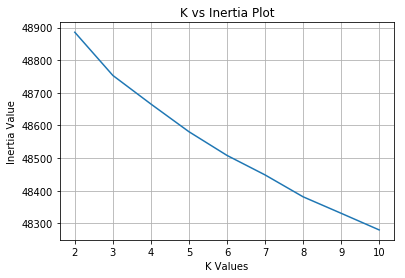

In [35]:
import matplotlib.pyplot as plt
plt.plot(k_values,INERTIA_2)
plt.grid(True)
plt.title("K vs Inertia Plot")
plt.xlabel("K Values")
plt.ylabel("Inertia Value")
plt.show()

In [64]:
print("OPTIMAL_K = 6")
FINAL_kmeans = KMeans(n_clusters=6).fit(X_TRAIN_TFIDF)

OPTIMAL_K = 6


### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

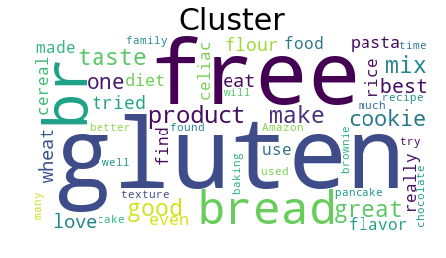

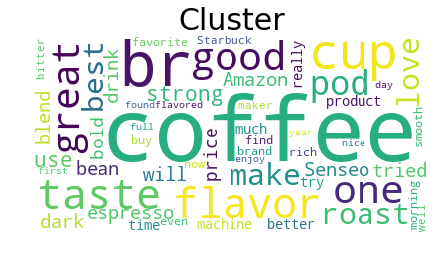

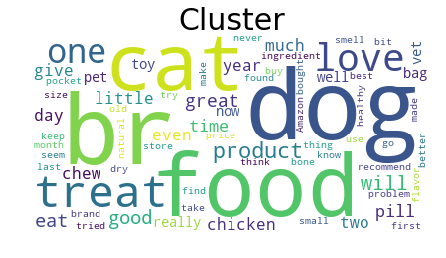

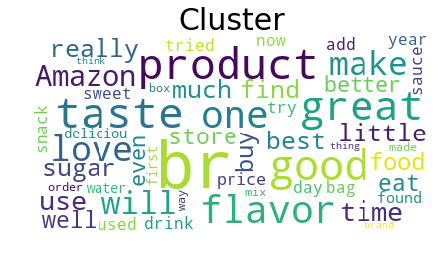

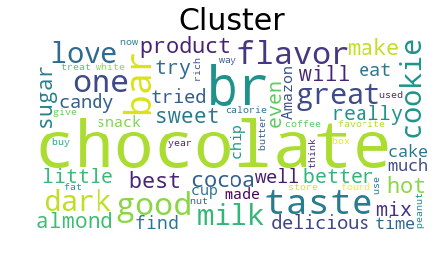

In [65]:
TFIDF_CLUSTER_1=[]
TFIDF_CLUSTER_2=[]
TFIDF_CLUSTER_3=[]
TFIDF_CLUSTER_4=[]
TFIDF_CLUSTER_5=[]
TFIDF_CLUSTER_6=[]
for i in range(FINAL_kmeans.labels_.shape[0]):
    if FINAL_kmeans.labels_[i] == 0:
        TFIDF_CLUSTER_1.append(TEXT[i])
    if FINAL_kmeans.labels_[i] == 1:
        TFIDF_CLUSTER_2.append(TEXT[i])
    if FINAL_kmeans.labels_[i] == 2:
        TFIDF_CLUSTER_3.append(TEXT[i])
    if FINAL_kmeans.labels_[i] == 3:
        TFIDF_CLUSTER_4.append(TEXT[i])
    if FINAL_kmeans.labels_[i] == 4:
        TFIDF_CLUSTER_5.append(TEXT[i])
    if FINAL_kmeans.labels_[i] == 5:
        TFIDF_CLUSTER_6.append(TEXT[i])
cloud(TFIDF_CLUSTER_1)
cloud(TFIDF_CLUSTER_2)
cloud(TFIDF_CLUSTER_3)
cloud(TFIDF_CLUSTER_4)
cloud(TFIDF_CLUSTER_5)
cloud(TFIDF_CLUSTER_6)

# CLUSTER 1: Gluten,bread,digestive,cookie (words in this cluster are mostly realted to breakfast food)
# CLUSTER 2:cofee,cup,roast,beans(words in this cluster is  about tea or coffee)
# CLUSTER 3:Cat,Dog,Chicken,eat,pet (about Animals)
# CLUSTER 4:product,love,good,great,time (it is contain words realted to customer positive review about product)
# CLUSTER 5:chocalate,dark,milk,delecious,almond,cookie(it is contain chocalate and its incredients) 

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

In [29]:
# Please write all the code with proper documentation
k_values = [2,3,4,5,6,7,8,9,10]
INERTIA_3 = []
for k in tqdm(k_values):
    kmeans = KMeans(n_clusters=k).fit(AV_TRAIN_BOW)
    INERTIA_3.append(kmeans.inertia_)
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [03:14<00:00, 30.08s/it]


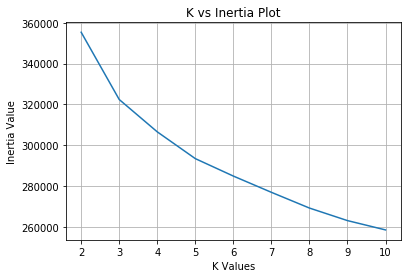

In [36]:
import matplotlib.pyplot as plt
plt.plot(k_values,INERTIA_3)
plt.grid(True)
plt.title("K vs Inertia Plot")
plt.xlabel("K Values")
plt.ylabel("Inertia Value")
plt.show()

In [66]:
print("OPTIMAL_K = 5")
FINAL_kmeans = KMeans(n_clusters=5).fit(AV_TRAIN_BOW)

OPTIMAL_K = 5


### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

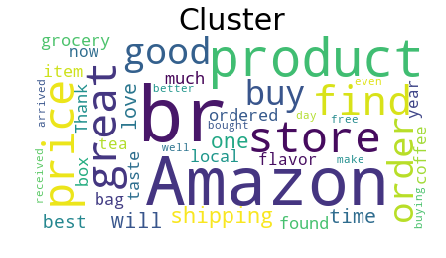

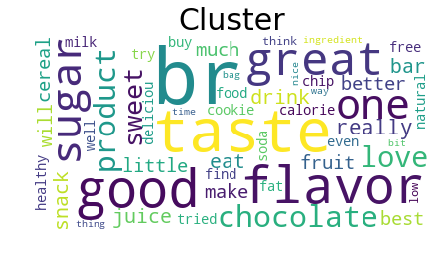

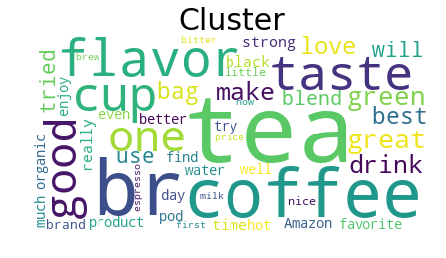

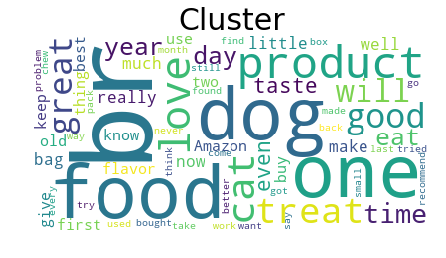

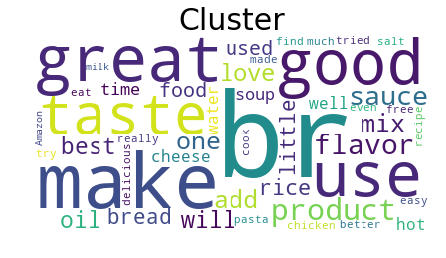

In [67]:
AV_CLUSTER_1=[]
AV_CLUSTER_2=[]
AV_CLUSTER_3=[]
AV_CLUSTER_4=[]
AV_CLUSTER_5=[]
for i in range(FINAL_kmeans.labels_.shape[0]):
    if FINAL_kmeans.labels_[i] == 0:
        AV_CLUSTER_1.append(TEXT[i])
    if FINAL_kmeans.labels_[i] == 1:
        AV_CLUSTER_2.append(TEXT[i])
    if FINAL_kmeans.labels_[i] == 2:
        AV_CLUSTER_3.append(TEXT[i])
    if FINAL_kmeans.labels_[i] == 3:
        AV_CLUSTER_4.append(TEXT[i])
    if FINAL_kmeans.labels_[i] == 4:
        AV_CLUSTER_5.append(TEXT[i])
cloud(AV_CLUSTER_1)
cloud(AV_CLUSTER_2)
cloud(AV_CLUSTER_3)
cloud(AV_CLUSTER_4)
cloud(AV_CLUSTER_5)

# CLUSTER 1: shipping,price,Amazon,store,order (words in this cluster are mostly realted to courier service)
# CLUSTER 2:sugar,chocolate,flavour,good,great(words in this cluster is  about chocolate and it taste)
# CLUSTER 3:Cat,Dog,product,taste(about Animals food and their taste)
# CLUSTER 4:product,love,good,great,time (it is contain words realted to customer positive review about product)
# CLUSTER 5:great,good,taste,will 

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [31]:
# Please write all the code with proper documentation
k_values = [2,3,4,5,6,7,8,9,10]
INERTIA_4 = []
for k in tqdm(k_values):
    kmeans = KMeans(n_clusters=k).fit(AV_TRAIN_TFIDF)
    INERTIA_4.append(kmeans.inertia_)
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [03:14<00:00, 30.11s/it]


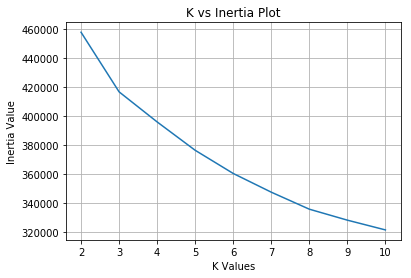

In [37]:
import matplotlib.pyplot as plt
plt.plot(k_values,INERTIA_4)
plt.grid(True)
plt.title("K vs Inertia Plot")
plt.xlabel("K Values")
plt.ylabel("Inertia Value")
plt.show()

In [68]:
print("OPTIMAL_K = 6")
FINAL_kmeans = KMeans(n_clusters=6).fit(AV_TRAIN_TFIDF)

OPTIMAL_K = 6


### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

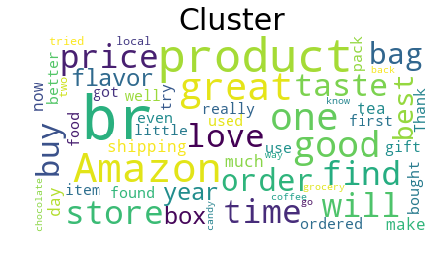

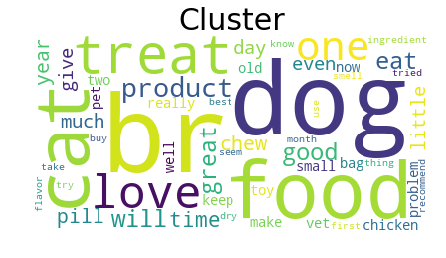

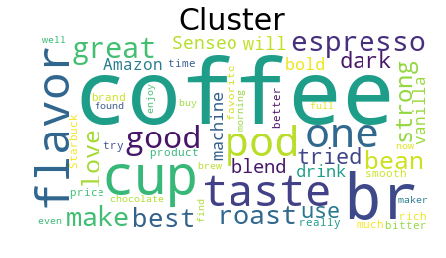

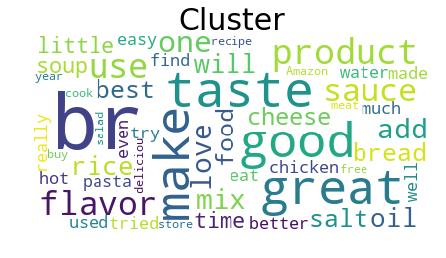

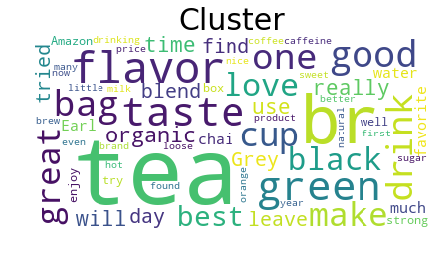

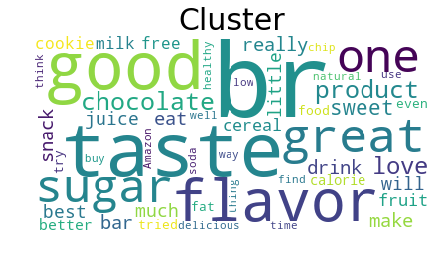

In [69]:
TFIDFW2V_CLUSTER_1=[]
TFIDFW2V_CLUSTER_2=[]
TFIDFW2V_CLUSTER_3=[]
TFIDFW2V_CLUSTER_4=[]
TFIDFW2V_CLUSTER_5=[]
TFIDFW2V_CLUSTER_6=[]
for i in range(FINAL_kmeans.labels_.shape[0]):
    if FINAL_kmeans.labels_[i] == 0:
        TFIDFW2V_CLUSTER_1.append(TEXT[i])
    if FINAL_kmeans.labels_[i] == 1:
        TFIDFW2V_CLUSTER_2.append(TEXT[i])
    if FINAL_kmeans.labels_[i] == 2:
        TFIDFW2V_CLUSTER_3.append(TEXT[i])
    if FINAL_kmeans.labels_[i] == 3:
        TFIDFW2V_CLUSTER_4.append(TEXT[i])
    if FINAL_kmeans.labels_[i] == 4:
        TFIDFW2V_CLUSTER_5.append(TEXT[i])
    if FINAL_kmeans.labels_[i] == 5:
        TFIDFW2V_CLUSTER_6.append(TEXT[i])
cloud(TFIDFW2V_CLUSTER_1)
cloud(TFIDFW2V_CLUSTER_2)
cloud(TFIDFW2V_CLUSTER_3)
cloud(TFIDFW2V_CLUSTER_4)
cloud(TFIDFW2V_CLUSTER_5)
cloud(TFIDFW2V_CLUSTER_6)

# CLUSTER 1:price,product,great,amazon (words in this cluster are mostly realted to product qualtiy and courier service)
# CLUSTER 2:dog,cat,food,product,chicken(words in this cluster is  about animals and their food product)
# CLUSTER 3:cofee,cup,espresso,strong(about coffee and tea)
# CLUSTER 4:soup,food,oil,sauce,salt(it is contain words about food)
# CLUSTER 5:tea,cup,balck,green,drink (contain words realted to coffe and tea)
# ClUSTER 6:good,taste,great,love,flavour (cutomer positive review)

In [25]:
NEW_AV_TRAIN_BOW =AV_TRAIN_BOW[0:5000]
NEW_AV_TRAIN_TFIDF =AV_TRAIN_TFIDF[0:5000]
NEW_LABEL = LABEL[0:5000]
NEW_TEXT = TEXT[0:5000]

## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [74]:
from sklearn.cluster import  AgglomerativeClustering
AC_AVW2V_1 = AgglomerativeClustering(n_clusters=2).fit(NEW_AV_TRAIN_BOW)

AC_AVW2V_2 = AgglomerativeClustering(n_clusters=5).fit(NEW_AV_TRAIN_BOW)

AC_AVW2V_3 = AgglomerativeClustering(n_clusters=7).fit(NEW_AV_TRAIN_BOW)

### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

Word Cloud Of 2 Clusters


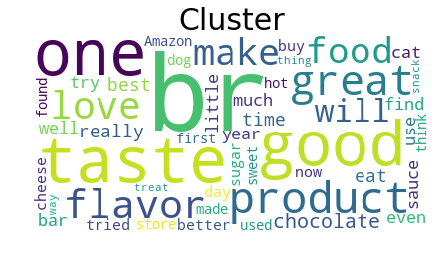

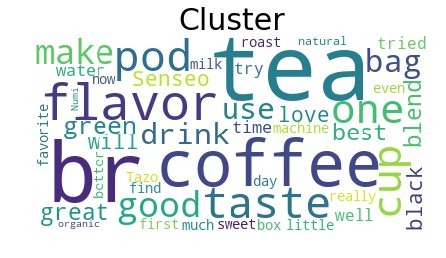

In [119]:
AC_CLUSTER_1 = []
AC_CLUSTER_2 = []
for i in range(AC_AVW2V_1.labels_.shape[0]):
    if AC_AVW2V_1.labels_[i] == 0:
        AC_CLUSTER_1.append(NEW_TEXT[i])
    if AC_AVW2V_1.labels_[i] == 1:
        AC_CLUSTER_2.append(NEW_TEXT[i])
print("Word Cloud Of 2 Clusters")
cloud(AC_CLUSTER_1)
cloud(AC_CLUSTER_2)

# CLUSTER 1:good,great,taste,flavour,product (words in this cluster are mostly realted to product qualtiy)
# CLUSTER 2: coffe,cup,tea,pod,green(words in this cluster is  about tea and coffee)

Word Cloud Of 5 Clusters


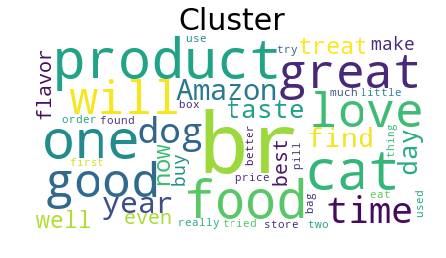

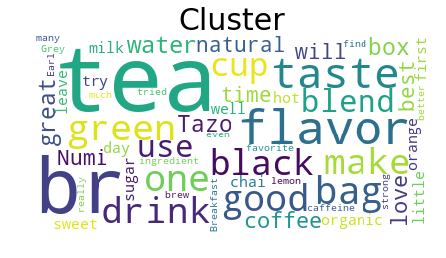

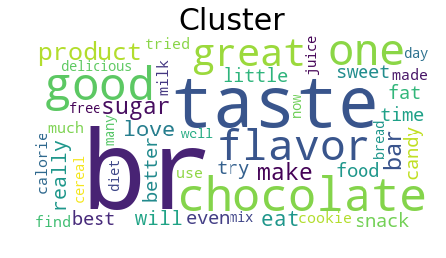

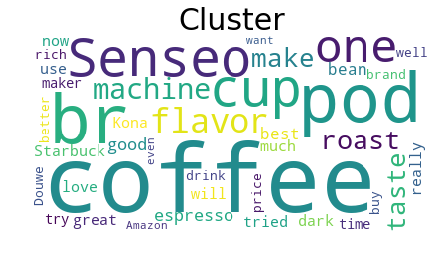

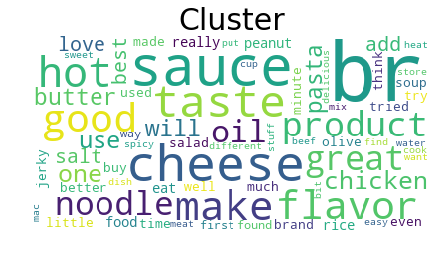

In [120]:
AC_CLUSTER_1 = []
AC_CLUSTER_2 = []
AC_CLUSTER_3 = []
AC_CLUSTER_4 = []
AC_CLUSTER_5 = []
for i in range(AC_AVW2V_2.labels_.shape[0]):
    if AC_AVW2V_2.labels_[i] == 0:
        AC_CLUSTER_1.append(NEW_TEXT[i])
    if AC_AVW2V_2.labels_[i] == 1:
        AC_CLUSTER_2.append(NEW_TEXT[i])
    if AC_AVW2V_2.labels_[i] == 2:
        AC_CLUSTER_3.append(NEW_TEXT[i])
    if AC_AVW2V_2.labels_[i] == 3:
        AC_CLUSTER_4.append(NEW_TEXT[i])
    if AC_AVW2V_2.labels_[i] == 4:
        AC_CLUSTER_5.append(NEW_TEXT[i])
print("Word Cloud Of 5 Clusters")
cloud(AC_CLUSTER_1)
cloud(AC_CLUSTER_2)
cloud(AC_CLUSTER_3)
cloud(AC_CLUSTER_4)
cloud(AC_CLUSTER_5)

# CLUSTER 1:product,great,food ,dog,cat(words in this cluster is  about animals and their food product)
# CLUSTER 2 Tea,green,black,coffee(words in this cluster is  about coffee and tea)
# CLUSTER 3:chocalate,flavour,good,taste,cookie(about sweet product and its taste)
# CLUSTER 4:cup,coffe,espresso,pod(it is contain words about tea and cofee)
# ClUSTER 5:cheese,sauce,noodle,paste,butter (about chinese food products)

Word Cloud Of 7 Clusters


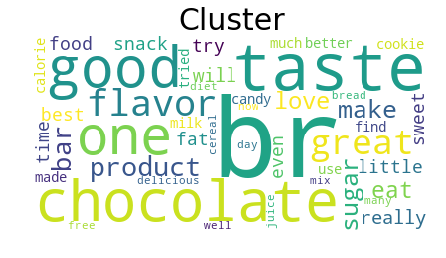

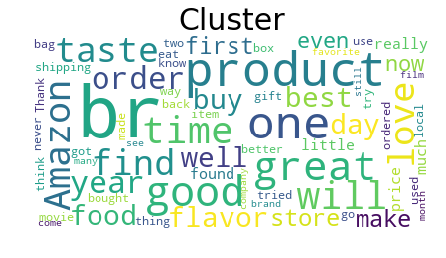

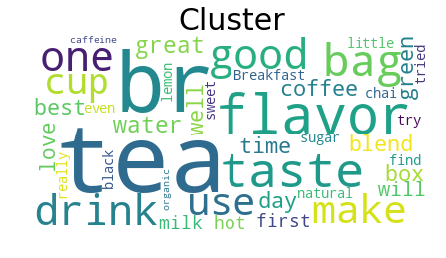

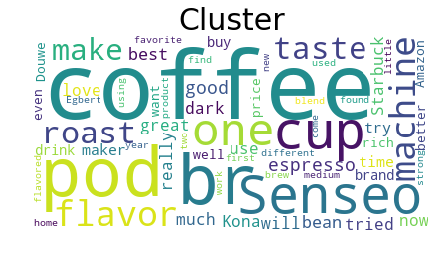

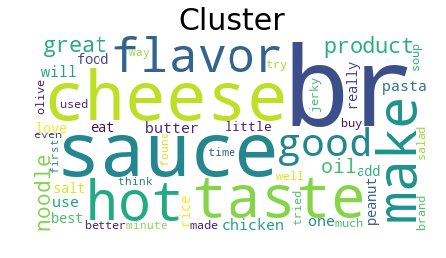

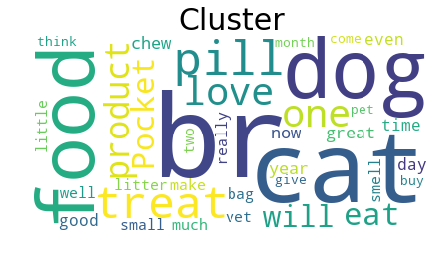

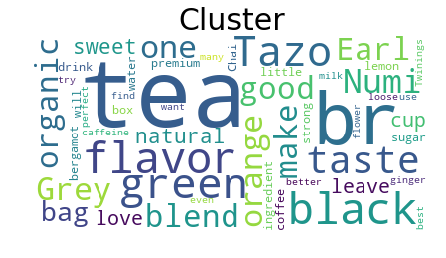

In [121]:
AC_CLUSTER_1 = []
AC_CLUSTER_2 = []
AC_CLUSTER_3 = []
AC_CLUSTER_4 = []
AC_CLUSTER_5 = []
AC_CLUSTER_6 = []
AC_CLUSTER_7 = []
for i in range(AC_AVW2V_3.labels_.shape[0]):
    if AC_AVW2V_3.labels_[i] == 0:
        AC_CLUSTER_1.append(NEW_TEXT[i])
    if AC_AVW2V_3.labels_[i] == 1:
        AC_CLUSTER_2.append(NEW_TEXT[i])
    if AC_AVW2V_3.labels_[i] == 2:
        AC_CLUSTER_3.append(NEW_TEXT[i])
    if AC_AVW2V_3.labels_[i] == 3:
        AC_CLUSTER_4.append(NEW_TEXT[i])
    if AC_AVW2V_3.labels_[i] == 4:
        AC_CLUSTER_5.append(NEW_TEXT[i])
    if AC_AVW2V_3.labels_[i] == 5:
        AC_CLUSTER_6.append(NEW_TEXT[i])
    if AC_AVW2V_3.labels_[i] == 6:
        AC_CLUSTER_7.append(NEW_TEXT[i])
print("Word Cloud Of 7 Clusters")
cloud(AC_CLUSTER_1)
cloud(AC_CLUSTER_2)
cloud(AC_CLUSTER_3)
cloud(AC_CLUSTER_4)
cloud(AC_CLUSTER_5)
cloud(AC_CLUSTER_6)
cloud(AC_CLUSTER_7)

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [78]:
from sklearn.cluster import  AgglomerativeClustering
AC_AVW2V_1 = AgglomerativeClustering(n_clusters=2).fit(NEW_AV_TRAIN_TFIDF)

AC_AVW2V_2 = AgglomerativeClustering(n_clusters=5).fit(NEW_AV_TRAIN_TFIDF)

AC_AVW2V_3 = AgglomerativeClustering(n_clusters=7).fit(NEW_AV_TRAIN_TFIDF)

### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

Word Cloud Of 2 Clusters


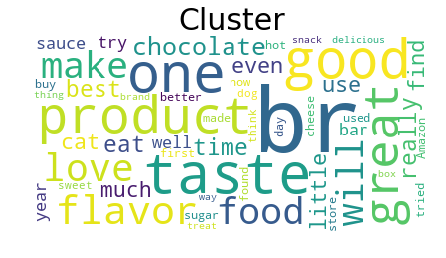

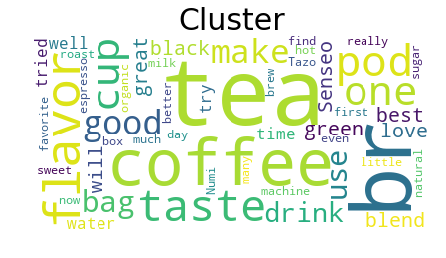

In [79]:
AC_CLUSTER_1 = []
AC_CLUSTER_2 = []
for i in range(AC_AVW2V_1.labels_.shape[0]):
    if AC_AVW2V_1.labels_[i] == 0:
        AC_CLUSTER_1.append(TEXT[i])
    if AC_AVW2V_1.labels_[i] == 1:
        AC_CLUSTER_2.append(TEXT[i])
print("Word Cloud Of 2 Clusters")
cloud(AC_CLUSTER_1)
cloud(AC_CLUSTER_2)

# CLUSTER 1:chocalate,flavour,good,taste,love(about sweet product and its taste)
# CLUSTER 2 Tea,cup,green,coffee(words in this cluster is  about coffee and tea)

Word Cloud Of 5 Clusters


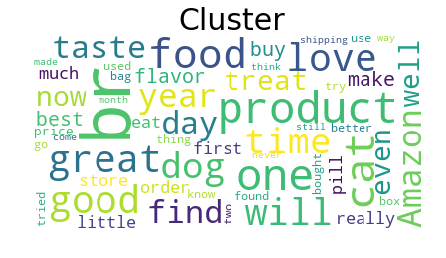

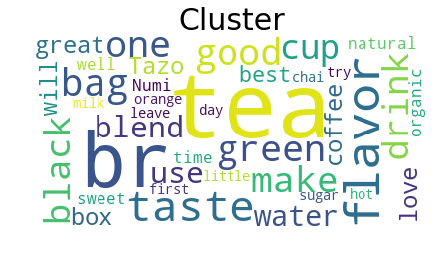

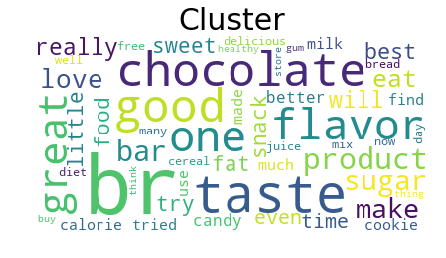

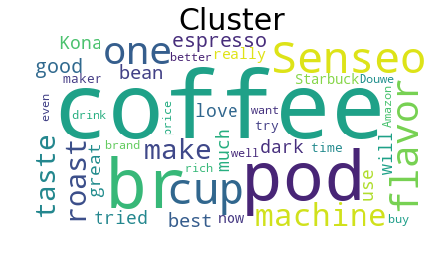

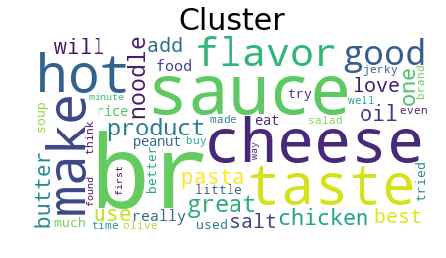

In [123]:
AC_CLUSTER_1 = []
AC_CLUSTER_2 = []
AC_CLUSTER_3 = []
AC_CLUSTER_4 = []
AC_CLUSTER_5 = []
for i in range(AC_AVW2V_2.labels_.shape[0]):
    if AC_AVW2V_2.labels_[i] == 0:
        AC_CLUSTER_1.append(NEW_TEXT[i])
    if AC_AVW2V_2.labels_[i] == 1:
        AC_CLUSTER_2.append(NEW_TEXT[i])
    if AC_AVW2V_2.labels_[i] == 2:
        AC_CLUSTER_3.append(NEW_TEXT[i])
    if AC_AVW2V_2.labels_[i] == 3:
        AC_CLUSTER_4.append(NEW_TEXT[i])
    if AC_AVW2V_2.labels_[i] == 4:
        AC_CLUSTER_5.append(NEW_TEXT[i])
print("Word Cloud Of 5 Clusters")
cloud(AC_CLUSTER_1)
cloud(AC_CLUSTER_2)
cloud(AC_CLUSTER_3)
cloud(AC_CLUSTER_4)
cloud(AC_CLUSTER_5)

# CLUSTER 1:good,great,taste,flavour,product (words in this cluster are mostly realted to product qualtiy)
# CLUSTER 2 Tea,cup,green,coffee(words in this cluster is  about coffee and tea)
# CLUSTER 3:chocalate,flavour,good,taste,love(about sweet product and its taste)
# CLUSTER 4:cup,coffe,espresso,pod(it is contain words about tea and cofee)
# ClUSTER 5: cheese,sauce,noodle,butter,chicken(words about chinese food)


Word Cloud Of 7 Clusters


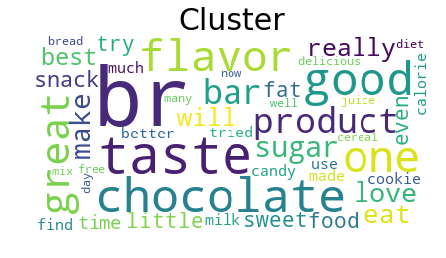

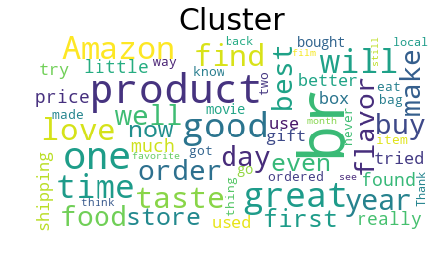

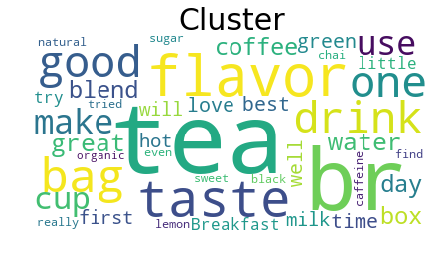

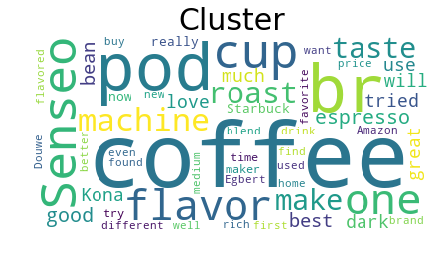

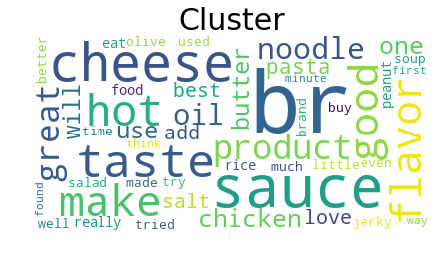

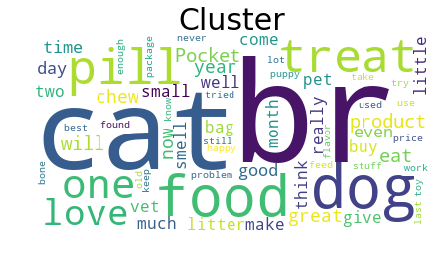

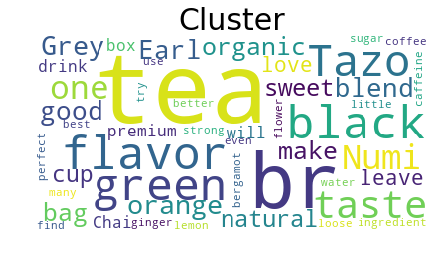

In [122]:
AC_CLUSTER_1 = []
AC_CLUSTER_2 = []
AC_CLUSTER_3 = []
AC_CLUSTER_4 = []
AC_CLUSTER_5 = []
AC_CLUSTER_6 = []
AC_CLUSTER_7 = []
for i in range(AC_AVW2V_3.labels_.shape[0]):
    if AC_AVW2V_3.labels_[i] == 0:
        AC_CLUSTER_1.append(NEW_TEXT[i])
    if AC_AVW2V_3.labels_[i] == 1:
        AC_CLUSTER_2.append(NEW_TEXT[i])
    if AC_AVW2V_3.labels_[i] == 2:
        AC_CLUSTER_3.append(NEW_TEXT[i])
    if AC_AVW2V_3.labels_[i] == 3:
        AC_CLUSTER_4.append(NEW_TEXT[i])
    if AC_AVW2V_3.labels_[i] == 4:
        AC_CLUSTER_5.append(NEW_TEXT[i])
    if AC_AVW2V_3.labels_[i] == 5:
        AC_CLUSTER_6.append(NEW_TEXT[i])
    if AC_AVW2V_3.labels_[i] == 6:
        AC_CLUSTER_7.append(NEW_TEXT[i])
print("Word Cloud Of 7 Clusters")
cloud(AC_CLUSTER_1)
cloud(AC_CLUSTER_2)
cloud(AC_CLUSTER_3)
cloud(AC_CLUSTER_4)
cloud(AC_CLUSTER_5)
cloud(AC_CLUSTER_6)
cloud(AC_CLUSTER_7)

# CLUSTER 1:good,great,taste,flavour,product,sweet,love,chocalte (words in this cluster are mostly realted to sweet product qualtiy)
# CLUSTER 2 Amazon,order,product,store,day
# CLUSTER 3:Tea,breakfast,milk,cup,coffe,green(words in this cluster is  about coffee and tea)
# CLUSTER 4:cup,coffe,espresso,pod(it is contain words about tea and cofee)
# ClUSTER 5: cheese,sauce,noodle,butter,chicken(words about chinese food)
# CLUSTER 6: cat,dog,food,love(ANimal food )
# CLUSTER 7: tea,black,green,chai(words related to tea )

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

In [26]:
from sklearn.cluster import  DBSCAN

In [27]:
MIN_POINTS = NEW_AV_TRAIN_BOW[0].shape[0]

In [28]:
MIN_POINTS

50

In [39]:
import numpy as np
DISTANCE = []

for DATA_POINT in NEW_AV_TRAIN_BOW:
        temp = np.sort(np.linalg.norm(NEW_AV_TRAIN_BOW-DATA_POINT,axis=1))
        DISTANCE.append(temp[MIN_POINTS])
SORT_DIST = np.sort(np.array(DISTANCE))

In [40]:
POINT_INDEX = [i for i in range(len(NEW_AV_TRAIN_BOW))]

Text(0,0.5,'DISTANCE')

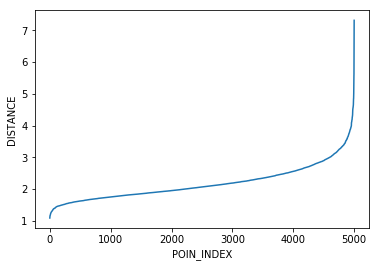

In [41]:
plt.plot(POINT_INDEX,SORT_DIST)
plt.xlabel("POIN_INDEX")
plt.ylabel('DISTANCE')

In [61]:
print("BEST EPSILON VALUE AS : 3.5")

BEST EPSILON VALUE AS : 3.5


### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

In [62]:
DB = DBSCAN(eps=3.5, min_samples=MIN_POINTS).fit(NEW_AV_TRAIN_BOW)
labels = DB.labels_ + 1

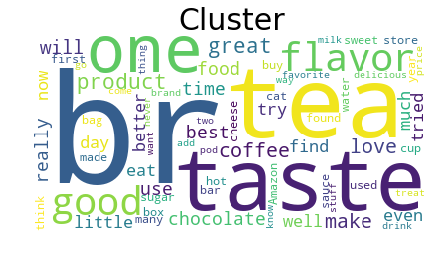

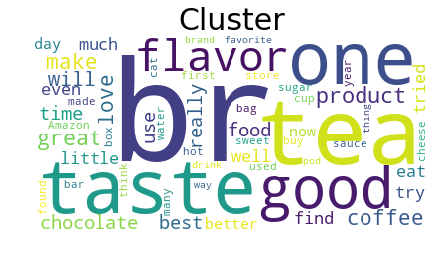

In [63]:
NUMBER_OF_CLUST = len(set(labels))
for j in range(0,NUMBER_OF_CLUST):
    cluster = []
    for i in range(0,labels.shape[0]):
        cluster.append(NEW_TEXT[i])
    cloud(cluster)
    

(5000,)

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

Text(0,0.5,'DISTANCE')

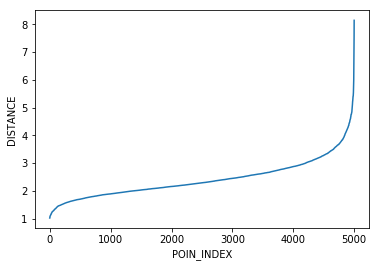

In [64]:
MIN_POINTS = NEW_AV_TRAIN_TFIDF[0].shape[0]


import numpy as np
DISTANCE = []

for DATA_POINT in NEW_AV_TRAIN_TFIDF:
        temp = np.sort(np.linalg.norm(NEW_AV_TRAIN_TFIDF-DATA_POINT,axis=1))
        DISTANCE.append(temp[MIN_POINTS])
SORT_DIST = np.sort(np.array(DISTANCE))
POINT_INDEX = [i for i in range(len(NEW_AV_TRAIN_TFIDF))]

plt.plot(POINT_INDEX,SORT_DIST)
plt.xlabel("POIN_INDEX")
plt.ylabel('DISTANCE')

### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

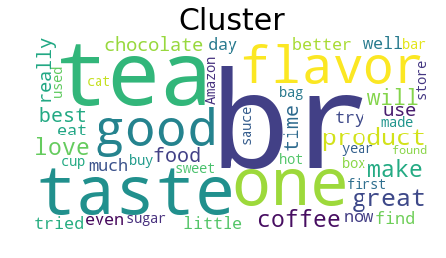

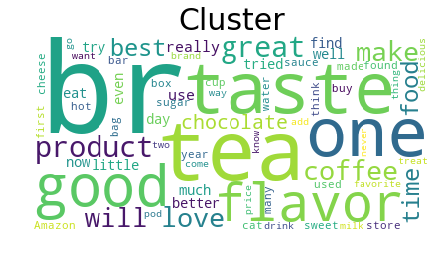

In [65]:
DB = DBSCAN(eps=3.5, min_samples=MIN_POINTS).fit(NEW_AV_TRAIN_TFIDF)
labels = DB.labels_ + 1
NUMBER_OF_CLUST = len(set(labels))
for j in range(0,NUMBER_OF_CLUST):
    cluster = []
    for i in range(0,labels.shape[0]):
        cluster.append(NEW_TEXT[i])
    cloud(cluster)
    

Both cluster contain preety much similar kind of words such as: Tea,cofee,taste,flavour,good

# [6] Conclusions

# I have took 50K points for K_means clustering and 5k points for DBSCAN and Agglomerative clustering

In [66]:
# Please compare all your models using Prettytable library. 
# You can have 3 tables, one each for kmeans, agllomerative and dbscan

# Please compare all your models using Prettytable library

from prettytable import PrettyTable
X = PrettyTable()

print("="*50+"K_MEANS"+"="*50)

X.field_names = ["VECTORIZER","Optimal Number of Cluster"]
X.add_row(["BOW",5])
X.add_row(["TFIDF",6])
X.add_row(["AVGW2V",5])
X.add_row(["TFIDFW2V",6])
print(X)

Y = PrettyTable()
print("="*50+"DBSCAN"+"="*50)
print("I have took Min points is equal: 2*dimension of data points")

Y.field_names = ["VECTORIZER","Optimal EPSILON"]
Y.add_row(["AVGW2V",3.5])
Y.add_row(["TFIDFW2V",3.5])
print(Y)


Z = PrettyTable()
print("="*50+"Agglomerative"+"="*50)


Z.field_names = ["VECTORIZER","Number of Cluster I Tried"]
Z.add_row(["AVGW2V","[2,5,7]"])
Z.add_row(["TFIDFW2V","[2,5,7]"])
print(Z)


==================================================K_MEANS==================================================
+------------+---------------------------+
| VECTORIZER | Optimal Number of Cluster |
+------------+---------------------------+
|    BOW     |             5             |
|   TFIDF    |             6             |
|   AVGW2V   |             5             |
|  TFIDFW2V  |             6             |
+------------+---------------------------+
==================================================DBSCAN==================================================
I have took Min points is equal: 2*dimension of data points
+------------+-----------------+
| VECTORIZER | Optimal EPSILON |
+------------+-----------------+
|   AVGW2V   |       3.5       |
|  TFIDFW2V  |       3.5       |
+------------+-----------------+
==================================================Agglomerative==================================================
+------------+---------------------------+
| VECTORIZER | Number of C

REfrence: https://github.com/abhishek-km23/Amazon-fine-food-review-analysis/blob/master/Amazon-fine-food-review%20-%20K-Means%2C%20Agglomerative%20%26%20DBSCAN%20Clustering.pdf